In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<h1> A Markov matrix (or stochastic matrix) </h1>

<p> Gives the probability of reaching a set of states given a set of starting states. Here's a basic example of what such a Markov chain would look if we wanted to model the weather in the evening given the weather in the morning: </p>

<img src="markov.png">

The starting "state" is listed on the left, while the column gives the final outcome. If we wanted to know the probability of Evening Sun given that it there was Morning rain, we would get 0.25 - a 25% chance of that outcome. Note that each row of this matrix is normalized, a statement that if you start in a state, there is a 100% chance that something happens. Nothing tricky here.


We can use this concept to build 

In [2]:
np.random.seed(30)
characters = list('abcdefghijklmnopqrstuvwxyz ')
cipher     = np.random.permutation(characters)

In [3]:
# take jumbled code to english
correct_map  = {code:   actual for code, actual in zip(cipher, characters)}
# take english to jumbled code
jumbler      = {actual: code for code, actual in correct_map.items()}
# indices of correct english
alpha_lookup = {letter: i for i, letter in enumerate(characters)}

In [4]:
def clean_chapter(doc):
    intermediate = re.sub(r'[^a-z]', ' ', doc)  
    return re.sub(r"\s\s+", " ", intermediate)

In [5]:
def combine_chapters(chapters):
    docs = [np.loadtxt(f'./moby_dick/chapter_{chap}.txt', dtype=str) for chap in chapters]
    docs = [" ".join(doc) for doc in docs]
    docs = [clean_chapter(doc) for doc in docs]
    return " ".join(docs)

In [6]:
train_chapters = combine_chapters(np.arange(1, 40))
test_chapters  = combine_chapters([50, 60])

test_chapters[:100]

'chapter the hyena there are certain queer times and occasions in this strange mixed affair we call l'

In [7]:
def make_cooccurrence_matrix(corpus, smooth_factor=0.01):
    """
    Matrix of counts
    
    first index is starting char, 
    second is following char
    """
    counts = np.zeros(shape=(len(characters), len(characters)))
    last = None
    for index, char in enumerate(corpus):
        if index == 0:
            last = alpha_lookup[char]
            continue
            
        current = alpha_lookup[char]
        counts[last, current] += 1
        last = current
    
    return counts + smooth_factor

In [8]:
def make_transition_matrix(corpus, smooth_factor=0.01):
    mx = make_cooccurrence_matrix(corpus, smooth_factor)
    total_ocs = np.sum(mx, axis=1).reshape(-1, 1)
    return mx / total_ocs

In [9]:
tm = make_transition_matrix(train_chapters)

In [10]:
# these should be about the same (up to a smoothing factor)
# this is the fraction of times 'b' follows 'a'
tm[0, 1], train_chapters.count('ab') / train_chapters.count('a')

(0.028496143625383514, 0.02849604221635884)

In [11]:
# logprob of observation is np.sum(np.log(make_transition_matrix(english) * make_cooccurrence_matrix(observation)))

In [12]:
transition_matrix = make_transition_matrix(train_chapters)

In [13]:
def logprob(train_transition_matrix, observation):
    observed_data = make_cooccurrence_matrix(observation, smooth_factor=1e-4)
    return np.sum(np.log(train_transition_matrix * observed_data))

In [24]:
logprob(transition_matrix, train_chapters)

-4738.146570173234

In [25]:
logprob(transition_matrix, test_chapters)

-7493.351510127829

In [32]:
# for pre, post in np.where(make_cooccurrence_matrix('hello world', smooth_factor=0)):
#     print(characters[pre], characters[post])

ValueError: too many values to unpack (expected 2)

In [39]:
np.where(make_cooccurrence_matrix('hello world', smooth_factor=0)).r

AttributeError: 'tuple' object has no attribute 'ravel'

MCMC steps:

    1) pick random cipher
    Until convergence:
        2) decode text
        3) calculate log likelihood
        4) use MH criterion to decide whether to keep new cipher

In [16]:
def decipher_string(ciphered_string, decoder):
    """
    Decode a ciphered text.
    
    Decoder: dict mapping {ciphered char: unciphered char}
    """
    new_str = ''
    
    for char in ciphered_string:
        new_str += decoder[char]
        
    return new_str


In [17]:
def encipher_message(unciphered_string, encoder):
    return decipher_string(unciphered_string, encoder)

In [18]:
def propose_cipher(original_cipher):
    """
    Swap two elements of the cipher at random
    """
    new_cipher = original_cipher.copy()
    char1, char2 = np.random.choice(characters, size=2, replace=False)
    
    char1_val = original_cipher[char1]
    char2_val = original_cipher[char2]
    
    new_cipher[char1] = char2_val
    new_cipher[char2] = char1_val
    
    return new_cipher

In [19]:
start_cipher = {ciph: actual for actual, ciph in 
                zip(np.random.choice(characters, size=27, replace=False), np.random.choice(characters, size=27, replace=False))}
ciphered_doc = encipher_message(test_chapters, start_cipher)

In [20]:
ciphered_doc[:100]

'sthrlqpgltqgtxqkhgltqpqghpqgsqplhwkgceqqpglwzq ghkmgassh wak gwkgltw g lphkdqgzwuqmghoohwpgiqgshbbgb'

In [21]:
def accept_proposed_cipher(proposed_loglike, original_loglike):
    prob_ratio = np.exp(proposed_loglike - original_loglike)
    uniform_random = np.random.random()
    
    return prob_ratio > uniform_random

In [22]:
n_iterations = 5000
current_cipher = start_cipher
likes = []

for cycle in range(n_iterations):
    prop_cipher = propose_cipher(current_cipher)
    prop_decoded_text = decipher_string(ciphered_doc, prop_cipher)
    
    if cycle % 20 == 0:
        print("\nCycle:", cycle, prop_decoded_text[:30])
        
    og_decoded_text = decipher_string(ciphered_doc, current_cipher)
    
    prop_loglike = logprob(transition_matrix, prop_decoded_text)
    og_loglike  = logprob(transition_matrix, og_decoded_text)
    
    if accept_proposed_cipher(proposed_loglike=prop_loglike, original_loglike=og_loglike):
        current_cipher = prop_cipher
        likes += [prop_loglike]
    else:
        likes += [og_loglike]


Cycle: 0  ltpbcrdblcdlucvtdblcrcdtrcd c

Cycle: 20 wltihbrvhlbvldbctvhlbrbvtrbvwb

Cycle: 40 nctboauvocavcfaxtvocauavtuavna

Cycle: 60 ton wzuvwozvojzhnvwozuzvnuzvtz

Cycle: 80 zvq tcuntvcnvxcbqntvcucnqucnzc

Cycle: 100 yuqlbxvnbuxnudxgqnbuxvxnqvxnyx

Cycle: 120 vyqbtrentyrnygrpqntyrernqernvr

Cycle: 140 irzqlmxnlrmnrjmpznlrmxmnzxmnim

Cycle: 160 eazbguxrgaura upzrgauxurzxureu

Cycle: 180 yvzuimbqivmqvdmazqivmbmqzbmqym

Cycle: 200 vjeut zitj ijd yeitj z iez iv 

Cycle: 220 yhomagqiahgihvg oiahgqgioqgiyg

Cycle: 240 sujokziakuzauwz jakuzizajizasz

Cycle: 260 fdcixzvjxdzjdqztcjxdzvzjcvzjfz

Cycle: 280 febihlmjheljeylqbjhelmljbmljfl

Cycle: 300 wtvkyqmjytqjtaqsvjytqmqjvmqjwq

Cycle: 320 dwhtcqmpcwqpwnqshpcwqmqphmqpdq

Cycle: 340 seqtnhlynehyevhfqynehlhyqlhysh

Cycle: 360  vlkohqrovhrvthplrovhqhrlqhr h

Cycle: 380 rxhdcq bcxqbxlqghbcxq qbh qbrq

Cycle: 400 ctboeaiwetawtsagbwetaiawbiawca

Cycle: 420 zwspyjhtywjtwojgstywjhjtshjtzj

Cycle: 440 zxupyiajyxijxfilujyxiaijuaijzi

Cycle: 460 hc ab


Cycle: 3760 ieqt mco emoebmwqo emcmoqcmoim

Cycle: 3780 uehyxmctxemtevmwhtxemcmthcmtum

Cycle: 3800 uec fhgsfehsenhwcsfehghscghsuh

Cycle: 3820 ujckorveojrejfrhceojrvrecvreur

Cycle: 3840 ocikq veqc ecw hieqc v eiv eo 

Cycle: 3860 mxwkq ceqx exg iweqx c ewc em 

Cycle: 3880 omgkdsiedmsemfsxgedmsisegiseos

Cycle: 3900 omgkictbimcbmncxgbimctcbgtcboc

Cycle: 3920 snakcofmcnomnpoxamcnofomafomso

Cycle: 3940 znbfdc vdncvnpcrbvdnc cvb cvzc

Cycle: 3960 snwcdakpdnapnyavwpdnakapwkapsa

Cycle: 3980 myvcdakndyanybaovndyakanvkanma

Cycle: 4000 mqcudajndqanqvaecndqajancjanma

Cycle: 4020 ulxiwaqywlaylgaexywlaqayxqayua

Cycle: 4040 tvxiynlcyvncvbnjxcyvnlncxlnctn

Cycle: 4060 bylgtdhctydcyndjlctydhdclhdcbd

Cycle: 4080 bvxguk euvkevnkhxeuvk kex kebk

Cycle: 4100 bozrny knoykowyhzknoy ykz ykby

Cycle: 4120 fkzghuajhkujkwuezjhkuaujzaujfu

Cycle: 4140 rkpuwqygwkqgkaqspgwkqyqgpyqgrq

Cycle: 4160 wthpjivljtiltaidhljtivilhvilwi

Cycle: 4180 fthqimvyitmytwmdhyitmvmyhvmyfm

Cycle: 4200 pthiqkyfqtkftekohfq

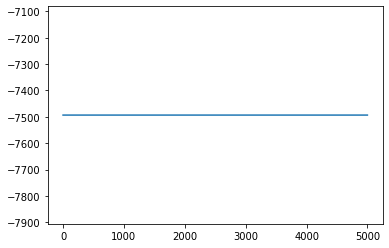

In [23]:
plt.plot(likes)